In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

# 도구
from langgraph.prebuilt.tool_node import ToolNode, tools_condition

In [ ]:
from langchain_tavily import TavilySearch

In [6]:
# 1. tool 세팅
search_tool = TavilySearch(max_results=5)
tools = [search_tool]

# 2. State 정의
class State(TypedDict):
    messages : Annotated[list, add_messages]
    
# 3. LLM + tool 연결
model = ChatOpenAI(
    model = "gpt-4.1-mini",
    temperature=0
)
llm_with_tool = model.bind_tools(tools)

# 4. chatbot 노드 정의
def agent_chatbot(state : State):
    answer = llm_with_tool.invoke(state['messages'])
    return {'messages' : [answer] }

# 5. 그래프 초기화 & 노드 추가
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", agent_chatbot)

# 6. 도구 노드 생성
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 7-1. 조건부 엣지 설정
graph_builder.add_conditional_edges(
    source="chatbot",
    path = tools_condition,
    path_map= {"tools" : "tools", END : END}
)

# 7-2. 전체 엣지 연결(나머지 부분 연결하는 것)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 8. 그래프 컴파일
graph = graph_builder.compile()

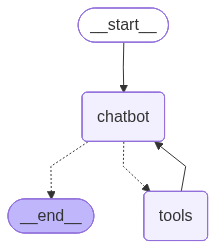

In [7]:
graph

In [10]:
question = "2025년 석촌역에 10월에 축제 하는거 알아? 우선 그 축제부터 찾고, 이후에 세부내용 다시 말해줘"

for evt in graph.stream({"messages": question}, stream_mode="values"):
    for key, value in evt.items():
        print("-"*30, key, "-"*30)
        value[-1].pretty_print()

------------------------------ messages ------------------------------
================================ Human Message =================================

2025년 석촌역에 10월에 축제 하는거 알아? 우선 그 축제부터 찾고, 이후에 세부내용 다시 말해줘
------------------------------ messages ------------------------------
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_Vnf31FkdszMIjoPNSqZHyinA)
 Call ID: call_Vnf31FkdszMIjoPNSqZHyinA
  Args:
    query: 2025년 10월 석촌역 축제
------------------------------ messages ------------------------------
================================= Tool Message =================================
Name: tavily_search

{"query": "2025년 10월 석촌역 축제", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.tiktok.com/discover/10%EC%9B%94-%EC%84%9D%EC%B4%8C%ED%98%B8%EC%88%98-%EC%B6%95%EC%A0%9C-2025%EB%85%84", "title": "10월 석촌호수 축제 2025년 - TikTok", "content": "5일 뒤 시작되는 석촌호수 빛축제 석촌호수에서 열리는 가을, 겨울 대표축제 루미나리에가 10/